In [66]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import pandas as pd
import os
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
import shap


In [68]:
from xgboost import XGBRegressor

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
#afcar_2021 =pd.read_table('./Data/AFCARS_Data/FC2021v1.tab')
afcar_2021 = pd.read_csv('/content/drive/MyDrive/TAG/FC2021v1.tab', sep ='\t')

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [71]:
afcar_2021['DISREASN'].value_counts()

99    391094
1     100772
3      53771
5      25150
4      19599
2      12540
6       2327
7        562
8        372
Name: DISREASN, dtype: int64

In [72]:
afcar_2021.RecNumbr.nunique()

606180

In [73]:
val_to_keep = 1
adopted_or_still_in_fc = afcar_2021[afcar_2021.DISREASN.isin([val_to_keep,99])]

In [74]:
req_cols = ['LifeLOS','WHITE','STATE','CHBEHPRB','CLINDIS','EVERADPT','XIXMEDCD','ABANDMNT','IVEFC','IVAAFDC','PRTSDIED','RELINQSH','TOTALREM','SEX','AMIAKN','ASIAN','BLKAFRAM','HAWAIIPI','UNTODETM','HISORGIN','MR','VISHEAR','PHYDIS'
           ,'EmotDist','OTHERMED','AGEADOPT','MANREM','PHYABUSE','SEXABUSE','NEGLECT','AAPARENT','DAPARENT',
           'AACHILD','DACHILD','CHILDIS','PRTSJAIL','NOCOPE','HOUSING',
           'SSIOTHER','NOA','RU13','DISREASN']#'IVEAA',

In [75]:
req_df = adopted_or_still_in_fc[req_cols]

In [76]:
val = req_df['DISREASN'].apply(lambda p:int(p==val_to_keep))
req_df.loc[:,'IS_REUNIFIED'] = val


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
req_df = req_df.drop(columns={'DISREASN'})

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [79]:
def plot_feature_importance(importance,names,model_type):

        #Create arrays from feature importance and feature names
        feature_importance = np.array(importance)
        feature_names = np.array(names)

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
        fi_df = fi_df.iloc[:9,:]
        #Define size of bar plot
        plt.figure(figsize=(10,8))
        #Plot Searborn bar chart
        sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
        #Add chart labels
        plt.title(model_type + 'FEATURE IMPORTANCE')
        plt.xlabel('FEATURE IMPORTANCE')
        plt.ylabel('FEATURE NAMES')

In [80]:
req_df = req_df.dropna()

In [81]:
req_df.dropna()['IS_REUNIFIED'].value_counts()

0    277445
1     71860
Name: IS_REUNIFIED, dtype: int64

In [82]:
X = req_df.drop(columns={'IS_REUNIFIED'})
y = req_df['IS_REUNIFIED']

In [83]:
import numpy as np
from sklearn.utils import resample

X_oversampled, y_oversampled = resample(X[y == 0],y[y == 0],replace=False,n_samples=X[y == 1].shape[0],random_state=123)
X_balanced = np.vstack((X[y == 1], X_oversampled))
y_balanced = np.hstack((y[y == 1], y_oversampled))


In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Xgboost

In [ ]:
req_cols_dict = {'LifeLOS':'Total days in FC','STATE':'State','XIXMEDCD':'Medicaid Eligible','EVERADPT':'Adopted before','TOTALREM':'Number of Removals',
           'WHITE':'White','CHBEHPRB':'Behavioral Problem','CLINDIS':'Clinical Disability','MANREM':'Manner of Removal','DAPARENT':'Drug Addicted Parent','ABANDMNT':'Abandoned','IVEFC':'IVE Payments',
                'PRTSDIED':'Parents Died','RELINQSH':'Parents relinquished rights'}

In [ ]:
X_train= pd.DataFrame(X_train)

X_train.columns = X.columns

X_train = X_train.rename(columns=req_cols_dict)

In [ ]:
X_test = pd.DataFrame(X_test)

X_test.columns = X.columns

X_test = X_test.rename(columns=req_cols_dict)

In [ ]:
X_test

In [ ]:
from xgboost import XGBClassifier

In [ ]:
(len(y_train)-y_train.sum())/y_train.sum()

In [ ]:
(len(y)-y.sum())/y.sum()

(y.sum())/len(y)

In [ ]:
xgb = XGBClassifier(n_estimators=200,random_state = 123, colsample_bytree=0.8)
xgb.fit(X_train, y_train)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
metrics.f1_score(y_pred=y_pred,y_true=y_test)

In [ ]:
metrics.roc_auc_score(y_score=y_pred,y_true=y_test)

In [ ]:
metrics.confusion_matrix(y_pred=y_pred,y_true=y_test)

In [ ]:
metrics.precision_score(y_pred=y_pred,y_true=y_test)

In [ ]:
metrics.recall_score(y_pred=y_pred,y_true=y_test)

In [ ]:
xgb.feature_importances_

In [ ]:
import numpy as np

In [ ]:
plot_feature_importance(xgb.feature_importances_,X_test.columns,'XGBoost')

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


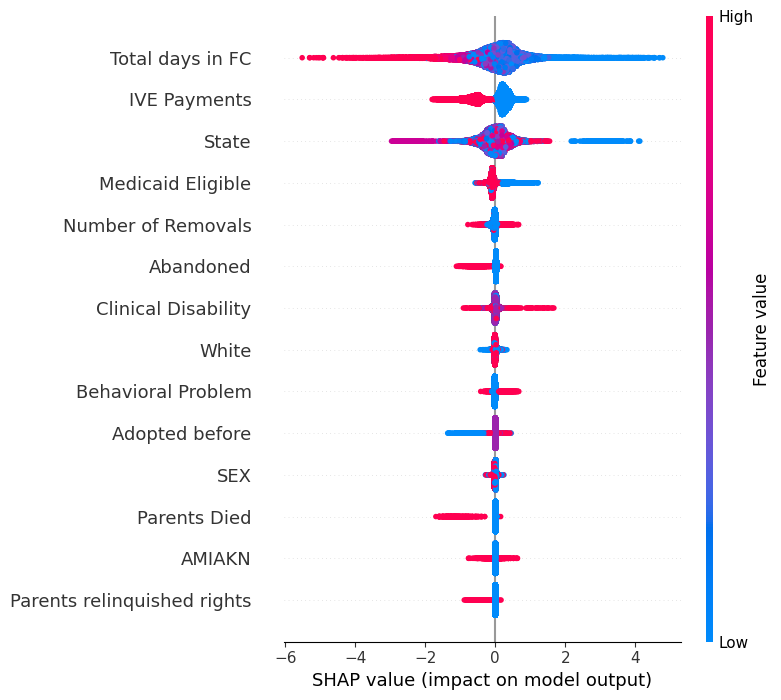

In [65]:
shap.summary_plot(shap_values[:,:len(req_cols_dict)], X_test.iloc[:,:len(req_cols_dict)])


# EDA of Important Variables

In [ ]:
life_os = req_df[['LifeLOS','IS_REUNIFIED']]

In [ ]:
req_df[['LifeLOS','IS_REUNIFIED']].groupby('IS_REUNIFIED').mean()

,LifeLOS
IS_REUNIFIED,
0,758.435038
1,473.770025


In [ ]:
life_os.LifeLOS.max()

7590.0

In [ ]:
num_bins = 20
bins = [i*365 for i in range(num_bins)]
labels = [i for i in range(1,num_bins)]
life_os['binned'] = pd.cut(life_os['LifeLOS'], bins=bins, labels=labels)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
p = life_os.groupby('binned').mean()['IS_REUNIFIED']

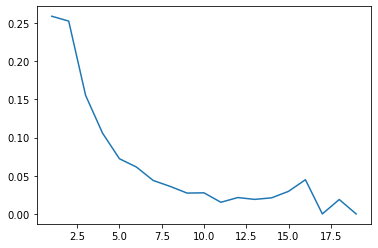

In [ ]:

plt.plot(p)

In [ ]:
state = req_df[['STATE','IS_REUNIFIED']]

In [ ]:
state_wise = state.groupby('STATE').mean()['IS_REUNIFIED']

In [ ]:
state_wise_reunf  = state_wise.sort_values(ascending=False)

In [ ]:
state_abbs = afcar_2021[['STATE','St']].drop_duplicates()

In [ ]:
pd.DataFrame(state_wise_reunf).merge(state_abbs,how='inner',on='STATE')

,STATE,IS_REUNIFIED,St
0,56,0.379369,WY
1,15,0.299604,HI
2,19,0.290184,IA
3,16,0.284825,ID
4,18,0.277552,IN
5,30,0.277414,MT
6,32,0.264683,NV
7,53,0.256083,WA
8,49,0.255172,UT
9,44,0.254165,RI
